<a href="https://colab.research.google.com/github/dsibi/yandex_praktikum_da/blob/main/event_analytics_in_mobile_app/event_analytics_in_mobile_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Исследование поведения пользователей в приложении**

---

## Описание проекта

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.
Изучим воронку событий. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/ A/ B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/ A/ B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также поможет понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/ A/ B-эксперимента будем работать с одними и теми же данными.

##Описание данных

Каждая запись в логе — это действие пользователя, или событие:
*  EventName — название события;
*  DeviceIDHash — уникальный идентификатор пользователя;
*  EventTimestamp — время события;
*  ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Импортируем все необходимые нам библиотеки, далее новые библиотеки будем добавлять сюда же

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import transforms
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth
import warnings
warnings.simplefilter('ignore')

Установим безлимитную ширину колонки при выводе, чтобы названия в колонках выводились полностью.

In [ ]:
pd.set_option('display.max_colwidth', None)

##Шаг 1. Загрузим данные

---



Чтение файлов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
app_log=pd.read_csv('/content/drive/MyDrive/Edu/Data Analysis/9.5_Сборый проект 2/data/logs_exp.csv', delim_whitespace=True)
app_log.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
210786,MainScreenAppear,2201216441003038354,1565120846,246
233906,OffersScreenAppear,5241439681088310317,1565191365,246
218143,CartScreenAppear,5615816265506611467,1565161509,247
23130,PaymentScreenSuccessful,2590691682508707697,1564668647,246
76041,MainScreenAppear,8357517652235019958,1564806301,246
111891,MainScreenAppear,3544085356884362414,1564901525,247
152427,MainScreenAppear,2708356845268272195,1565000698,246
66029,CartScreenAppear,2816391585125949645,1564763875,248
19973,MainScreenAppear,3366760593494744640,1564663769,246
112302,CartScreenAppear,6631893489958899803,1564902295,247


##Шаг 2. Подготовим данные к анализу

---



###2.1. Изучим общую информацию 

In [ ]:
df_list = [app_log]
for df in df_list:   
    print('Первые 5 строк датафрейма')
    print('-'*80)
    display(df.head(5))
    print('-'*80)
    print('Типы данных и общая информация')
    print(df.info())
    print('-'*80)
    print('Наличие дубликатов: {}'.format(df.duplicated().sum()))
    print('-'*80)
    print('Наличие пропусков')
    print('-'*80)
    print(df.isna().sum())
    print('Стат данные')
    print('-'*80)
    display(df.describe())

Первые 5 строк датафрейма
--------------------------------------------------------------------------------


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


--------------------------------------------------------------------------------
Типы данных и общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
--------------------------------------------------------------------------------
Наличие дубликатов: 413
--------------------------------------------------------------------------------
Наличие пропусков
--------------------------------------------------------------------------------
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Стат данные
---------------------------------------------------------------

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


1. Названия столбцов: требуется корректировка.
2. Типы данных: необходимо сконвертировать формат Unix-времени и разделить этот столбец на столбцы даты и времени.
3. Дубликаты: 413 строк.
4. Пропуски: отсутствуют.
5. Аномалии в данных: отсутствуют.

###2.2. Преобразуем данные

####2.2.1. Скорректируем названия столбцов

In [ ]:
app_log = app_log.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time', 'ExpId':'group_id'})
app_log.columns

Index(['event_name', 'user_id', 'event_time', 'group_id'], dtype='object')

####2.2.2. Изменим типы данных

In [ ]:
app_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group_id    244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Cконвертируем формат Unix-времени и разделим этот столбец на столбцы даты и времени:

In [ ]:
app_log['event_time'] = app_log['event_time'].astype('datetime64[s]')
app_log['date'] = [d.date() for d in app_log['event_time']]
app_log['time'] = [d.time() for d in app_log['event_time']]
app_log['date'] = pd.to_datetime(app_log.date)
app_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group_id    244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
 5   time        244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


####2.2.3. Удалим дубликаты

In [ ]:
app_log=app_log.drop_duplicates()
app_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group_id    243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
 5   time        243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.0+ MB


##Шаг 3. Изучим и проверим данные

---



###3.1. Сколько всего событий в логе?

In [ ]:
log_num=app_log.groupby('event_name')['user_id'].count().reset_index()
log_num.columns = ['event_name', 'event_amount']
log_num=log_num.sort_values(by = 'event_amount', ascending = False)
log_num

,event_name,event_amount
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


В логе всего 5 различных событий, разница в количестве их возникновения от самого максимального к самому минимальному – более чем в 100 раз.

###3.2. Сколько всего пользователей в логе?

In [ ]:
users_num=app_log['user_id'].nunique()
f'Всего {users_num} пользователь в логе'

'Всего 7551 пользователь в логе'

###3.3. Сколько в среднем событий приходится на пользователя?

In [ ]:
event_user=round((app_log.groupby('user_id')['event_name'].count()).mean(),0)
f'Всего на 1 пользователя в среднем приходится {event_user} события'

'Всего на 1 пользователя в среднем приходится 32.0 события'

Пользователь может совершить несколько заказов, да и в течение недели может заходить и просматривать список товаров.

###3.4. Период данных

Построим гистограмму по датам, чтобы определить полноту данных в датасете:

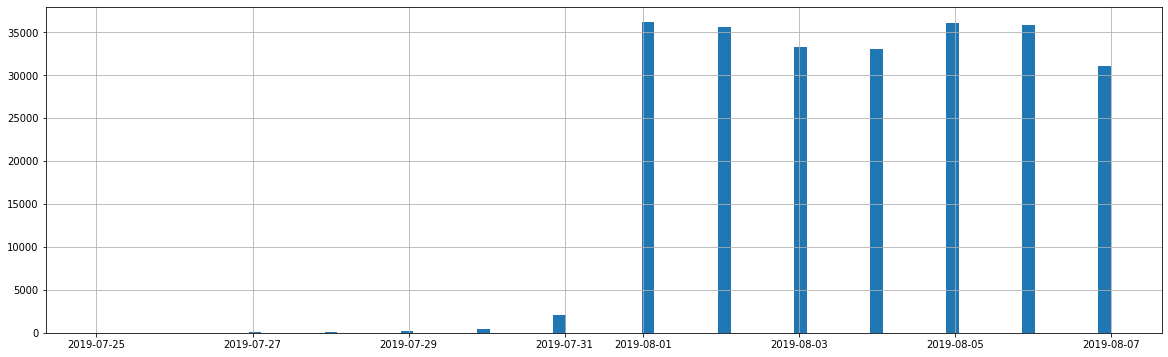

In [ ]:
plt.figure(figsize=(20,6))
app_log['date'].hist(bins=80);

В логе данные не за все дни являются полными, поэтому удалим данные по 2019-07-31 включительно:

In [ ]:
app_log=app_log.drop(app_log[app_log['date'] < '2019-08-01'].index)

In [ ]:
print("В результате удаления потеряли", log_num['event_amount'].sum()-app_log.shape[0], "событий и", users_num-app_log['user_id'].nunique(), "пользователей, или")

В результате удаления потеряли 2826 событий и 17 пользователей, или


In [ ]:
print(round((1-app_log.shape[0]/log_num['event_amount'].sum())*100,2), "% событий и", round((1-app_log['user_id'].nunique()/users_num)*100,2), "% пользователей")

1.16 % событий и 0.23 % пользователей


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп:

In [ ]:
app_log.nunique()

event_name         5
user_id         7534
event_time    174044
group_id           3
date               7
time           69316
dtype: int64

##Шаг 4. Изучим воронку событий

---



###4.1. События в логах

Посмотрим на события в логах и как часто они встречаются:

In [ ]:
log_num=app_log.groupby('event_name')['user_id'].count().reset_index()
log_num.columns = ['event_name', 'event_amount']
log_num=log_num.sort_values(by = 'event_amount', ascending = False)
log_num

,event_name,event_amount
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


###4.2. События и пользователи

Посчитаем сколько пользователей совершали каждое из этих событий, отсортируем события по числу пользователей:


In [ ]:
users_amount = app_log.pivot_table(index=['event_name'], values='user_id', aggfunc={'nunique','count'}).reset_index()
users_amount.columns = ['event_name', 'events_amount', 'unique_users_amount']
users_amount=users_amount.sort_values(by = 'unique_users_amount', ascending = False)
users_amount

,event_name,events_amount,unique_users_amount
1,MainScreenAppear,117328,7419
2,OffersScreenAppear,46333,4593
0,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


Посчитаем долю пользователей, которые хоть раз совершали событие:

In [ ]:
users_amount['users_perc']=round(users_amount['unique_users_amount']/app_log['user_id'].nunique()*100,2)
users_amount

,event_name,events_amount,unique_users_amount,users_perc
1,MainScreenAppear,117328,7419,98.47
2,OffersScreenAppear,46333,4593,60.96
0,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


Недобор 1,53 % пользователей по событию MainScreenAppear вызван тем, что на сессия включающая в себя этот экран началась накануне и в текущий датасет не попала, а также часть пользователей могла попасть в приложение в обход MainScreenAppear и попадать сразу, в OffersScreenAppear.

Лишь 11,15 % пользователей проходят обучение в приложении, можно задуматься об упразднении этого раздела приложения.


###4.3. Воронка событий

Последовательность цепочки событий выстраивается следующим образом: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful.

Добавим группировку по экспериментальным группам и посмотрим на то, согласуются ли данные разных групп между собой:

In [ ]:
events_by_groups=app_log.pivot_table(index=['event_name'], values='user_id', columns='group_id', aggfunc={'nunique'}).reset_index()
events_by_groups.columns = ['event_name', '246', '247', '248']
events_by_groups = events_by_groups.sort_values(by='248', ascending=False)
events_by_groups

,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Видим, что данные согласуются в разных группах, теперь можно строить воронку событий:

In [ ]:
fig = go.Figure(go.Funnel(
    y = ["Главный экран","Предложения/товары", "Корзина", "Оплата"],
    x = users_amount['unique_users_amount'],
    textinfo = "value+percent initial"
))
fig.show()

Почти половина пользователей пропадает после первого шага – 61,9 % переходит на экран Предложения/товары.

Полностью воронку событий проходит 47,7 % пользователей.


##Шаг 5. Изучим результаты эксперимента

---



###5.1. Количество пользователей в каждой экспериментальной группе

Проверим, что пользователи действительно попали в попали в разные группы:

In [ ]:
users_in_group = app_log.pivot_table(index=['user_id'], values='group_id', aggfunc={'nunique'}).reset_index()
users_in_group.columns = ['user_id', 'group_amount']
users_in_group.sort_values(by="group_amount", ascending=False)
users_in_group

,user_id,group_amount
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1
...,...,...
7529,9217594193087726423,1
7530,9219463515465815368,1
7531,9220879493065341500,1
7532,9221926045299980007,1


Число вхождений пользователей в каждую из групп равно 1 - разбивка по пользователям корректная.

Подсчитаем количество пользователей в каждой экспериментальной группе:

In [ ]:
users_by_groups = app_log.pivot_table(index=['group_id'], values='user_id', aggfunc={'nunique'}).reset_index()
users_by_groups.columns = ['group_id', 'unique_users_amount']
users_by_groups

,group_id,unique_users_amount
0,246,2484
1,247,2513
2,248,2537


Размеры групп несколько различаются, что говорит о неоптимальности разбиения данных по группам.

Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению.

### 5.2. Статистическая разница между контрольными группами

При проверке гипотез о равенстве среднего будем применять метод Z-тест (z-критерий Фишера), т.к. будем проводить сравнения двух независимых выборок большого размера. Критический уровень статистической значимости примем равным 5%.
Создадим функцию с применением поправки Бонферрони:

In [ ]:
def find_stat_value(successes1, successes2, trials1, trials2):
    alpha = 0.05
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    # пропорция успехов во второй группе:
    p2 = successes2/trials2 
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    # разница пропорций в датасетах
    difference = p1 - p2  
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = 1 - distr.cdf(z_value) 

    print('* p-значение: ', p_value)

    # применим поправку Бонферрони для множестенных сравнений в кол-ве 4 штук.
    bonferroni_alpha = alpha / 16
 
    if (p_value < bonferroni_alpha):
        print("* Результат:", "Нулевая гипотеза отвергнута: между долями есть значимая разница")
    else:
        print("* Результат:", "Нулевая гипотеза не отвергнута: нет оснований считать доли разными")

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Правильно, что ты создал функцию для проведения теста. Действительно, тестов проводить много, так что она не будет лишней. 
    
Также верно, что ты работаешь с долями относительно общего числа клиентов в группах. Ранее мы выяснили, что проход по всем этапам воронки не является обязательным, так что работать нудно именно относительно общего числа клиентов. 
    
</div>

Подготовим недостающие данные для теста – количество пользователей в каждой группе по событиям:

In [ ]:
users_by_events=app_log.pivot_table(index=['event_name'], columns='group_id', values='user_id', aggfunc={'nunique'}).reset_index()
users_by_events.columns = ['event_name', 'group_246','group_247', 'group_248']
users_by_events

,event_name,group_246,group_247,group_248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Сделаем попарное сравнение события **MainScreenAppear** между группами, в которых:

H0 - статистическая разница между группами отсутствует, т.е. доли пользователей совершивших событие в сравниваемых группах одинаковы

H1 - статистическая разница между группами присутствует, т.е. доли пользователей совершивших событие в сравниваемых группах различны

*  А/А-тест по группам 246 и 247

In [ ]:
find_stat_value(users_by_events.iloc[1]['group_246'],
                 users_by_events.iloc[1]['group_247'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                )  

* p-значение:  0.37852986160230495
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246 и 248

In [ ]:
find_stat_value(users_by_events.iloc[1]['group_246'],
                 users_by_events.iloc[1]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.1474860966777276
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[1]['group_247'],
                 users_by_events.iloc[1]['group_248'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.22935268083107574
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246+247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[1]['group_246']+users_by_events.iloc[1]['group_247'],
                 users_by_events.iloc[1]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount']+users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.14712263418589788
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


**Вывод:** наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами.

Сделаем аналогичные попарные сравнение для других событий в воронке продаж.

**OffersScreenAppear**

*  А/А-тест по группам 246 и 247

In [ ]:
find_stat_value(users_by_events.iloc[2]['group_246'],
                 users_by_events.iloc[2]['group_247'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                )  

* p-значение:  0.12404772892610905
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246 и 248

In [ ]:
find_stat_value(users_by_events.iloc[2]['group_246'],
                 users_by_events.iloc[2]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.10418102701369458
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[2]['group_247'],
                 users_by_events.iloc[2]['group_248'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.45989089152961304
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246+247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[2]['group_246']+users_by_events.iloc[2]['group_247'],
                 users_by_events.iloc[2]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount']+users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.21712774827594128
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


**CartScreenAppear**

*  А/А-тест по группам 246 и 247

In [ ]:
find_stat_value(users_by_events.iloc[0]['group_246'],
                 users_by_events.iloc[0]['group_247'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                )  

* p-значение:  0.11441686118998606
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246 и 248

In [ ]:
find_stat_value(users_by_events.iloc[0]['group_246'],
                 users_by_events.iloc[0]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.03921461618760058
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[0]['group_247'],
                 users_by_events.iloc[0]['group_248'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.28930989397698914
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246+247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[0]['group_246']+users_by_events.iloc[0]['group_247'],
                 users_by_events.iloc[0]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount']+users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.09087937642202193
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


**PaymentScreenSuccessful**

*  А/А-тест по группам 246 и 247

In [ ]:
find_stat_value(users_by_events.iloc[3]['group_246'],
                 users_by_events.iloc[3]['group_247'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                )  

* p-значение:  0.057283396565709244
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246 и 248

In [ ]:
find_stat_value(users_by_events.iloc[3]['group_246'],
                 users_by_events.iloc[3]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.1061276637848898
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[3]['group_247'],
                 users_by_events.iloc[3]['group_248'],
                 users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.6313292473098018
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


*  А/В-тест по группам 246+247 и 248

In [ ]:
find_stat_value(users_by_events.iloc[3]['group_246']+users_by_events.iloc[3]['group_247'],
                 users_by_events.iloc[3]['group_248'],
                 users_by_groups.iloc[0]['unique_users_amount']+users_by_groups.iloc[1]['unique_users_amount'],
                 users_by_groups.iloc[2]['unique_users_amount'],
                )  

* p-значение:  0.3002147141154352
* Результат: Нулевая гипотеза не отвергнута: нет оснований считать доли разными


**Вывод:** наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами.

###5.3. Анализ тестовой группы со скорректированным уровнем значимости


При увеличении статистической значимости до 0.1, увеличится критический регион, при попадании в который нулевую гипотезу отвергают. Вероятность попасть в него стала бы больше — увеличилась вероятность ошибки первого рода.

##Общий вывод
---

В данном исследовании были проведены следующие работы: 

1. открыт файл с данными и изучена общая информация

2. произведена подготовка данных:
* скорректированы названия столбцов;
* сконвертирован формат Unix-времени;
* удалены 413 дубликатов строк.

3. изучены и проверены данные:
* в логе всего 5 различных событий и 7551 пользователь;
* в среднем на 1 пользователя в среднем приходится 32 события;
* в логе обнаружены неравномерные данные, в связи с чем данные по 2019-07-31 включительно были удалены.


4. изучена воронку событий:
* почти половина пользователей пропадает после первого шага – 61,9 % переходит на экран Предложения/товары;
* полностью воронку событий проходит 47,7 % пользователей.
5. изучены результаты эксперимента:
* применен метод Z-тест (z-критерий Фишера) с критическим уровнем статистической значимости равным 5%, а также с учетом поправки Бонферрони;
* проведены попарные сравнения каждого пункта из воронки событий результатов групп A/A/B-эксперимента.


Проведенные статистические тесты не показали разницы между контрольными группами, поэтому можно сделать вывод о том, что изменение шрифтов во всём приложении не влияет на пользовательскую активность.

Дополнительно стоит отметить, что всю воронку событий проходит менее половины пользователей, что говорит о том, что необходимо провести дополнительный комплексный анализ работы отдельных модулей и функциональности приложения в целом.

Изменение шрифтов можно провести, однако это не увеличит показатели.